In [0]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [0]:
from keras.layers import Dense, Activation, Flatten, BatchNormalization, GRU
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt

'''
サンプルデータの生成
'''
fname = "jena_climate_2009_2016.csv"

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")    # ['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
lines = lines[1:]   # ['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30', ...]

# print(len(lines))     # 420551

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i, :] = values
    # float_data : Date Time を除く(420551, 14)の二次元テンソル
    # ['"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

'''
データの前処理
'''
mean = float_data[:200000].mean(axis=0)      # 訓練データ : 20000個の時間刻み
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Using TensorFlow backend.


In [0]:
'''
ジェネレータの生成
'''
# 時系列サンプルとその目標値を生成するジェネレータ
# data:不動小数点型のデータ配列(float_data), lookback:入力データの時間刻みをいくつ遡るか, delay:目標値の時間刻みをいくつ進めるか
# min_index,max_index:抽出する時間刻みの上限と下限を表すdata配列のインデックス, step:データをサンプリングするときの期間(6 <-> 60分 <->1時間 刻み)
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay -1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + max_index
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))     # 通常 len(rows) = batch_size
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]                  # rows[j]をlookbackだけ振り返り、stepだけ刻んで格納 (入力)
            targets[j] = data[rows[j] + delay][1]       # rows[j]からdelay後の温度T (正解)
        yield samples, targets

lookback = 1440*2     # 240*2時間 <-> 10*2日
step = 6//2            # 1/2時間
delay = 144         # 24時間 <-> 1日
batch_size = 4000

# 訓練ジェネレータ
train_gen = generator(
    float_data,
    lookback=lookback,
    delay = delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
# 検証ジェネレータ
val_gen = generator(
    float_data,
    lookback=lookback,
    delay = delay,
    min_index=200001,
    max_index=300000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
# テストジェネレータ
test_gen = generator(
    float_data,
    lookback=lookback,
    delay = delay,
    min_index=300001,
    max_index=None,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
# 訓練データ全体を調べるためにtrain_genから抽出する時間刻みの数
train_steps = (200000 - 1 - lookback) // batch_size
# 検証データ全体を調べるためにval_genから抽出する時間刻みの数
val_steps = (300000 - 200001 + lookback) // batch_size
# テストデータ全体を調べるためにval_genから抽出する時間刻みの数
test_steps = (len(float_data) - 30001 - lookback) // batch_size

'''
モデルの構築
'''
from keras.layers import Conv1D, MaxPooling1D

model = Sequential()
model.add(Conv1D(32, 5, activation = "relu", input_shape=(None, float_data.shape[-1]),))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 5, activation = "relu"))
model.add(GRU(
    32,
    dropout=0.1,
    recurrent_dropout=0.5,
))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss="mae", metrics=["acc"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
'''
学習
'''
early_stopping = EarlyStopping(monitor= "val_loss", patience= 10, verbose= 1)
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=train_steps,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks = [early_stopping]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
49/49 [==============================] - 103s 2s/step - loss: 0.3998 - acc: 0.0000e+00 - val_loss: 0.3231 - val_acc: 0.0000e+00
Epoch 2/40
49/49 [==============================] - 87s 2s/step - loss: 0.3464 - acc: 0.0000e+00 - val_loss: 0.3185 - val_acc: 0.0000e+00
Epoch 3/40
49/49 [==============================] - 88s 2s/step - loss: 0.3301 - acc: 0.0000e+00 - val_loss: 0.3035 - val_acc: 0.0000e+00
Epoch 4/40
49/49 [==============================] - 88s 2s/step - loss: 0.3182 - acc: 0.0000e+00 - val_loss: 0.2938 - val_acc: 0.0000e+00
Epoch 5/40
49/49 [==============================] - 87s 2s/step - loss: 0.3102 - acc: 0.0000e+00 - val_loss: 0.2802 - val_acc: 0.0000e+00
Epoch 6/40
49/49 [==============================] - 88s 2s/step - loss: 0.3058 - acc: 0.0000e+00 - val_loss: 0.2790 - val_acc: 0.0000e+00
Epoch 7/40
49/49 [==============================] - 87s 2s/step - loss: 0.3016 - acc: 0.0000e+00 - val_loss: 0.2989 - val_a

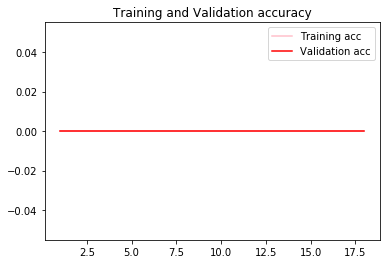

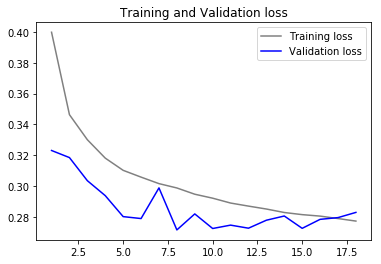

In [4]:
'''
評価
'''
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label="Training acc", color= "pink")
plt.plot(epochs, val_acc, label="Validation acc", color= "red")
plt.title("Training and Validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, label="Training loss", color= "gray")
plt.plot(epochs, val_loss, label="Validation loss", color= "blue")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

In [0]:
'''
オリジナルの誤差
'''
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]   # 温度データ
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()
print(0.29*std[1])